# Calibrating the the Incubator Temperature Dynamics

## Step 1: Get the calibration data

The data comes from an experiment where the heater was turned on, letting the incubator warm up for some time, and then turned off, before repeating.

In [1]:
# Get CSV file from an incubator dataset
import os

# Get the current working directory.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '4-Calibration', 'Current directory is not 4-Calibration'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

csv_file_path = os.path.join(parent_dir, 'incubator_dt', 'software', 'incubator', 'datasets', '20230501_calibration_empty_system', '20230501_calibration_empty_system.csv')

assert os.path.exists(csv_file_path), '20230501_calibration_empty_system.csv not found in the incubator repository.'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(csv_file_path)
data.head()

,time,t1,time_t1,t2,time_t2,t3,time_t3,average_temperature,heater_on,fan_on,execution_interval,elapsed
0,1682912554273107499,23.062,1682912554192856639,24.312,1682912554232822932,22.125,1682912554272705263,23.6870,False,False,3.0,1.025402
1,1682912557313698460,23.062,1682912557272792494,24.375,1682912557232848441,22.125,1682912557313344724,23.7185,False,False,3.0,1.064928
2,1682912560282455551,23.062,1682912560232232220,24.375,1682912560192178595,22.062,1682912560282224276,23.7185,False,False,3.0,1.031638
3,1682912563313803672,23.125,1682912563273056592,24.375,1682912563232827969,22.062,1682912563313317234,23.7500,False,False,3.0,1.061013
4,1682912566283347240,23.125,1682912566243313892,24.375,1682912566192896637,22.062,1682912566282895616,23.7500,False,False,3.0,1.028555


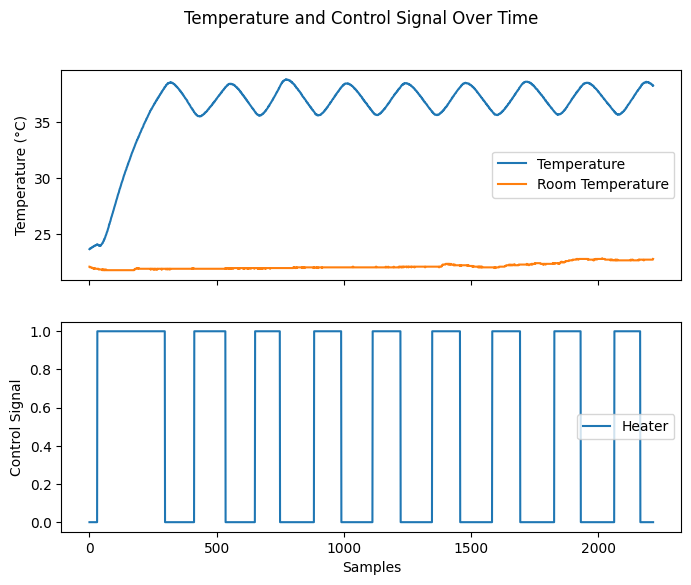

In [3]:
# Create subplots with shared X-axis for temperature and control signal.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

# Plot temperature data on the first subplot
ax1.plot(data.index, data.average_temperature, label='Temperature')
ax1.plot(data.index, data.t3, label='Room Temperature')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()

# Plot control signal data on the second subplot (heater on/off)
ax2.plot(data.index, data.heater_on, label='Heater')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Control Signal')
ax2.legend()

# Add a title to the shared X-axis
fig.suptitle('Temperature and Control Signal Over Time')

# Show the plots
plt.show()

## Step 2: Define the ODE System for the Incubator

We reuse the model created in [3-Physics-Modelling\2-ModellingIncubatorDynamics.ipynb](..\3-Physics-Modelling\2-ModellingIncubatorDynamics.ipynb), extended with the interpolated continuous functions from the dataset.

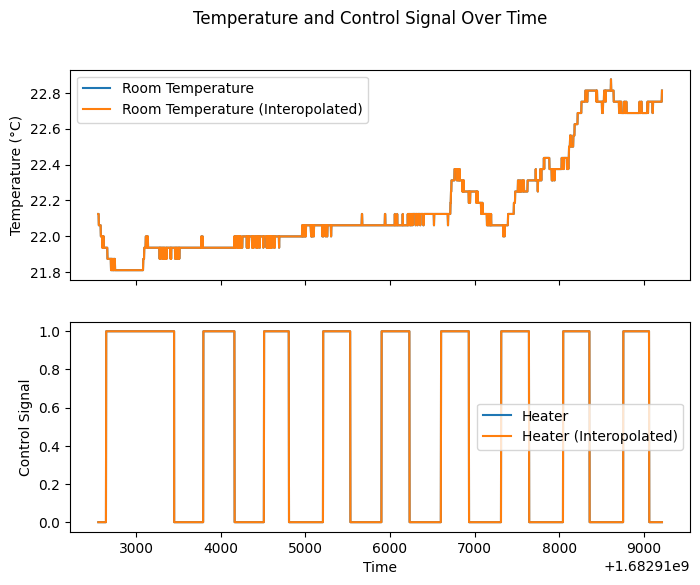

In [4]:
# Example of a varying power and room temperature
from scipy.interpolate import interp1d
import numpy as np

# Create lookup functions for model inputs from the data.
time_range = data["time"].to_numpy().astype(np.float64)

# Time has been stored in nanoseconds, so we need to convert it to seconds
time_range = time_range / 1e9

# interp1d returns a function of time, 
#  that finds the closest value in the data to the time given
heater_on_lookup_function = interp1d(time_range, data["heater_on"].to_numpy())
T_room_lookup_function = interp1d(time_range, data["t3"].to_numpy())

# Plot interpolated data vs original data. It should be fairly close.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
# Plot temperature data on the first subplot
ax1.plot(time_range, data.t3, label='Room Temperature')
ax1.plot(time_range, [T_room_lookup_function(t) for t in time_range], label='Room Temperature (Interopolated)')
ax1.set_ylabel('Temperature (°C)')
ax1.legend()

# Plot control signal data on the second subplot (heater on/off)
ax2.plot(time_range, data.heater_on, label='Heater')
ax2.plot(time_range, [heater_on_lookup_function(t) for t in time_range], label='Heater (Interopolated)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Control Signal')
ax2.legend()

# Add a title to the shared X-axis
fig.suptitle('Temperature and Control Signal Over Time')

# Show the plots
plt.show()

In [5]:
from scipy.integrate import solve_ivp

# ODE system
def incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br, Voltage, Current):
    Th, Tb = y
    Ph = Voltage*Current  # Power in (W)
    Tr = T_room_lookup_function(t)  # Interpolated room temperature at time t
    H_h = heater_on_lookup_function(t)  # Heater on/off switch at time t
    dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
    dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
    return [dTh_dt, dTb_dt]

# Parameters (arbitrary values for demonstration purposes)
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
G_hb = 10.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 5.0  # Heat transfer coefficient between box and room (W/C)
Voltage = 12.0  # Voltage of the Heater (V)
Current = 1.5  # Current of the Heater (A)

# Initial conditions
T_h0 = data.average_temperature[0]  # Initial heater temperature (C). Assumed to be the same as the initial box temperature and comes from initial value of the data.
T_b0 = data.average_temperature[0]  # Initial box temperature (C)
y0 = [T_h0, T_b0]  # Initial state vector

# Time span: same as the dataset
t_span = (time_range[0], time_range[-1])  # Start and end times
t_eval = time_range  # Times at which to evaluate the solution. Should match the dataset.

sol = solve_ivp(
        lambda t, y: incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br, Voltage, Current),
        t_span, y0, t_eval=t_eval)

sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 1.683e+09  1.683e+09 ...  1.683e+09  1.683e+09]
        y: [[ 2.369e+01  2.369e+01 ...  2.478e+01  2.476e+01]
            [ 2.369e+01  2.366e+01 ...  2.443e+01  2.441e+01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 824
     njev: 0
      nlu: 0

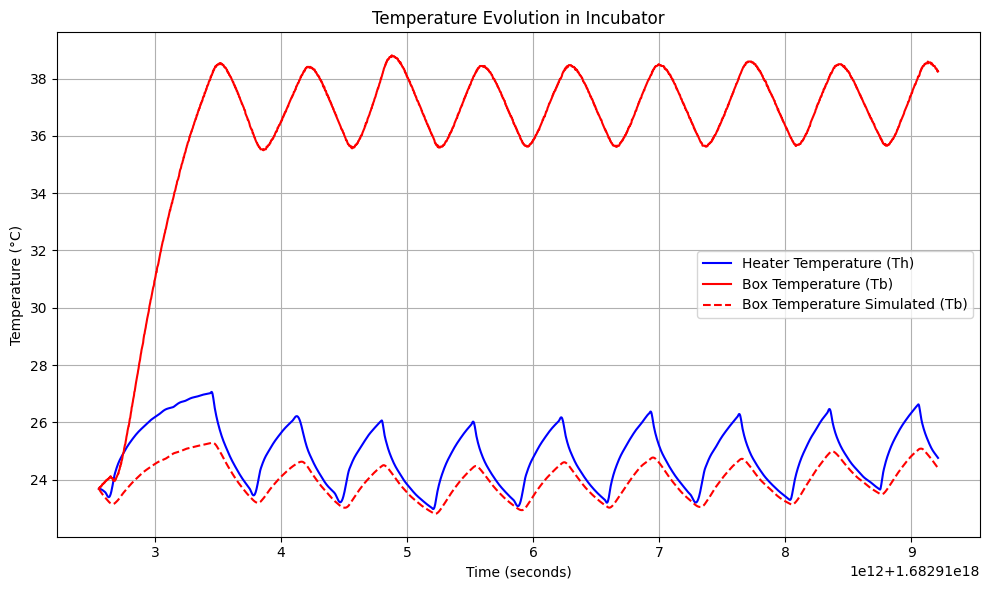

In [6]:
# Plot the results
Th_values = sol.y[0,:]
Tb_values = sol.y[1,:]

plt.figure(figsize=(10, 6))
plt.plot(data.time, Th_values, color='blue', label='Heater Temperature (Th)')
plt.plot(data.time, data.average_temperature, color='red', label='Box Temperature (Tb)')
plt.plot(data.time, Tb_values, color='red', linestyle="--", label='Box Temperature Simulated (Tb)')
plt.title('Temperature Evolution in Incubator')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now let us try out different values of some of the ODE parameters. Our goal is to make the dashed red line (simulated temperature of the box) match the continuous red line (temperature from the dataset).

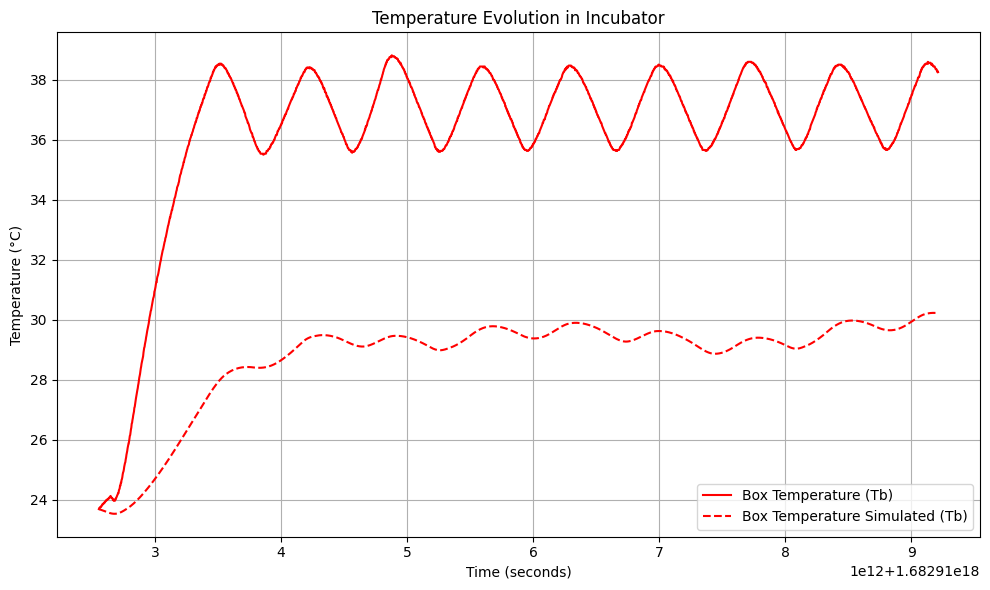

In [7]:
# Try changing the following values. As a first suggestion, we've decreased the values of the G_hb and G_br parameter.
Ch = 500.0  # Heat capacity of the heater (J/Kg/C)
Cb = 1000.0  # Heat capacity of the box (J/Kg/C)
G_hb = 1.0  # Heat transfer coefficient between heater and box (W/C)
G_br = 1.0  # Heat transfer coefficient between box and room (W/C)
Voltage = 12  # Voltage of the Heater (V)
Current = 1.5  # Current of the Heater (A)

sol = solve_ivp(
        lambda t, y: incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br, Voltage, Current),
        t_span, y0, t_eval=t_eval)

Th_values = sol.y[0,:]
Tb_values = sol.y[1,:]

plt.figure(figsize=(10, 6))
# Omit heater temperature as not important since we do not have heater temperature data
# plt.plot(data.time, Th_values, color='blue', label='Heater Temperature (Th)')
plt.plot(data.time, data.average_temperature, color='red', label='Box Temperature (Tb)')
plt.plot(data.time, Tb_values, color='red', linestyle="--", label='Box Temperature Simulated (Tb)')
plt.title('Temperature Evolution in Incubator')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Try changing the above parameters until the box temperature simulated matches the box temperature, or gets closer. You are effectively doing what the optimization algorithm will do.

## Step 2: Define Cost Function for the Optimization

The cost function is a function of the parameters, and should return a scalar value reflecting the fitness of those parameters. The strategy is, for each valuation of the parameters, run a simulation, and then compute the sum of squared errors between the simulated temperature and the temperature in the data.

In [8]:
# Convert average_temperature to numpy array for use in the cost function, for better efficiency.
average_temperature = data.average_temperature.to_numpy()

def cost(P_guess):
    Ch,Cb,G_hb,G_br,Voltage,Current = P_guess
    
    # Note that this part of the function depends on the initial values t_span, y0, and t_eval, defined in the previous cells. 
    sol = solve_ivp(
        lambda t, y: incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br, Voltage, Current),
        t_span, y0, t_eval=t_eval)

    # Check if simulation was successful
    if not sol.success:
        print(f"Cost for {P_guess}: Simulation failed")
        return 1e6  # Return a high cost to avoid this solution
    else:
        Tb_values = sol.y[1,:]
        differences = average_temperature - Tb_values
        sum_sq_dff = sum(differences**2)
        print(f"Cost for {P_guess}: {sum_sq_dff}")
        return sum_sq_dff

# Try different values for the parameters
#                Ch,       Cb,  G_hb, G_br,Voltage,Current
initial_guess = [500.0, 1000.0, 10.0, 5.0,  12.0,   1.5]
cost(initial_guess)

initial_guess = [300.0, 200.0, 1.0, 0.57,  12.0,   1.5]
cost(initial_guess)

Cost for [500.0, 1000.0, 10.0, 5.0, 12.0, 1.5]: 353625.4549952082
Cost for [300.0, 200.0, 1.0, 0.57, 12.0, 1.5]: 2659.5906556404675


2659.5906556404675

## Step 3: Run the Optimization

In [9]:
from scipy.optimize import least_squares

initial_guess = [300.0, 200.0, 1.6, 0.57,  12.0,   1.5]
res = least_squares(cost, initial_guess)
res

Cost for [300.   200.     1.6    0.57  12.     1.5 ]: 1820.9358336655193
Cost for [300.00000447 200.           1.6          0.57        12.
   1.5       ]: 1917.770783170009
Cost for [300.         200.00000298   1.6          0.57        12.
   1.5       ]: 1933.1115226942882
Cost for [300.         200.           1.60000002   0.57        12.
   1.5       ]: 1781.3867767673091
Cost for [300.         200.           1.6          0.57000001  12.
   1.5       ]: 1883.8273444008043
Cost for [300.         200.           1.6          0.57        12.00000018
   1.5       ]: 2151.067810193657
Cost for [300.         200.           1.6          0.57        12.
   1.50000002]: 2151.067810193657


C:\Users\D48113\AppData\Local\Temp\ipykernel_14988\2838486616.py:9: RuntimeWarning: overflow encountered in scalar multiply
  dTh_dt = (H_h * Ph - G_hb * (Th - Tb)) / Ch
C:\Users\D48113\AppData\Local\Temp\ipykernel_14988\2838486616.py:10: RuntimeWarning: overflow encountered in scalar multiply
  dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
C:\Users\D48113\AppData\Local\Temp\ipykernel_14988\2838486616.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  dTb_dt = (G_hb * (Th - Tb) - G_br * (Tb - Tr)) / Cb
C:\Users\D48113\AppData\Local\Temp\ipykernel_14988\4009910005.py:19: RuntimeWarning: overflow encountered in square
  sum_sq_dff = sum(differences**2)
C:\Users\D48113\AppData\Local\Temp\ipykernel_14988\4009910005.py:19: RuntimeWarning: overflow encountered in scalar add
  sum_sq_dff = sum(differences**2)


Cost for [300.50221826 200.87267066 -36.85898122  98.42288898  54.80435636
 343.93485086]: Simulation failed
Cost for [299.87444543 199.78183233  11.2147453  -23.89322225   1.29891091
 -84.10871271]: inf
Cost for [299.96861136 199.94545808   4.00368633  -5.54580556   9.32472773
 -19.90217818]: 5.157278889824979e+97
Cost for [299.99215284 199.98636452   2.20092158  -0.95895139  11.33118193
  -3.85054454]: 4.235907772053971e+17
Cost for [2.99998038e+02 1.99996591e+02 1.75023040e+00 1.87762152e-01
 1.18327955e+01 1.62363864e-01]: 245923.135739737
Cost for [299.99950955 199.99914778   1.6375576    0.47444054  11.95819887
   1.16559097]: 6027.430541132638
Cost for [299.99987739 199.99978695   1.6093894    0.54611013  11.98954972
   1.41639774]: 2008.8445191226842
Cost for [299.99996935 199.99994674   1.60234735   0.56402753  11.99738743
   1.47909944]: 2225.0145326067827
Cost for [299.99999234 199.99998668   1.60058684   0.56850688  11.99934686
   1.49477486]: 1424.6347274972543
Cost for [2

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.370e+03]
           x: [ 3.000e+02  2.000e+02  1.601e+00  5.685e-01  1.200e+01
                1.495e+00]
        cost: 937979.6000580977
         jac: [[-7.678e+04 -1.319e+05  2.565e+09 -2.681e+07 -4.220e+06
                -3.387e+07]]
        grad: [-1.052e+08 -1.807e+08  3.513e+12 -3.672e+10 -5.779e+09
               -4.639e+10]
  optimality: 3512903544298.0557
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00]
        nfev: 16
        njev: 3

Depending on the initial guess selected you may or may not be successful at finding a minimum for the optimization problem. It may help to get an initial guest that is as close as possible to the minimum and possibly incorporate constraints on the values of parameters based on your knowledge of the physics. For instance, all parameters must be at least positive values.

The following does just that. We know from literature and datasheets of the components what the possible bounds for the parameters are, so we define those.

In [ ]:
#       Ch,     Cb,    G_hb,   G_br,   Voltage, Current
bounds=([10.0,  10.0,  0.0,    0.0,    12.0,    1.0], 
        [500.0, 500.0, 5.0,    5.0,    13.0,    2.0])

initial_guess = [300.0, 200.0, 1.6, 0.57,  12.0,   1.5]

res = least_squares(cost, initial_guess, bounds=bounds)
res

Cost for [300.   200.     1.6    0.57  12.     1.5 ]: 1820.9358336655193
Cost for [300.00000447 200.           1.6          0.57        12.
   1.5       ]: 1917.770783170009
Cost for [300.         200.00000298   1.6          0.57        12.
   1.5       ]: 1933.1115226942882
Cost for [300.         200.           1.60000002   0.57        12.
   1.5       ]: 1781.3867767673091
Cost for [300.         200.           1.6          0.57000001  12.
   1.5       ]: 1883.8273444008043
Cost for [300.         200.           1.6          0.57        12.00000018
   1.5       ]: 2151.067810193657
Cost for [300.         200.           1.6          0.57        12.
   1.50000002]: 2151.067810193657
Cost for [299.99999991 199.9999999    1.60000008   0.56999997  12.
   1.4999999 ]: 1752.6020005180574
Cost for [300.00000438 199.9999999    1.60000008   0.56999997  12.
   1.4999999 ]: 1887.3347406239343
Cost for [299.99999991 200.00000288   1.60000008   0.56999997  12.
   1.4999999 ]: 1815.49555331019
Cost f

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.753e+03]
           x: [ 3.000e+02  2.000e+02  1.600e+00  5.700e-01  1.200e+01
                1.500e+00]
        cost: 1535806.8861099484
         jac: [[ 3.014e+07  2.110e+07  2.317e+09 -7.019e+08  2.051e+09
                 1.641e+10]]
        grad: [ 5.282e+10  3.699e+10  4.062e+12 -1.230e+12  3.595e+12
                2.876e+13]
  optimality: 15318388355384.475
 active_mask: [ 0  0  0  0 -1  0]
        nfev: 4
        njev: 2

Now we're more likely to successully converge on a minimum.

In [15]:
# Print optimal parameters:
Ch_opt, Cb_opt, G_hb_opt, G_br_opt, Voltage_opt, Current_opt = res.x
print(f"Optimal parameters:")
print(f"Ch: {Ch_opt}")
print(f"Cb: {Cb_opt}")
print(f"G_hb: {G_hb_opt}")
print(f"G_br: {G_br_opt}")
print(f"Voltage: {Voltage_opt}")
print(f"Current: {Current_opt}")

Optimal parameters:
Ch: 299.9999999113188
Cb: 199.999999899041
G_hb: 1.6000000796191973
G_br: 0.5699999660382852
Voltage: 12.000000000000002
Current: 1.4999998957468792


## Step 4: Plot Results

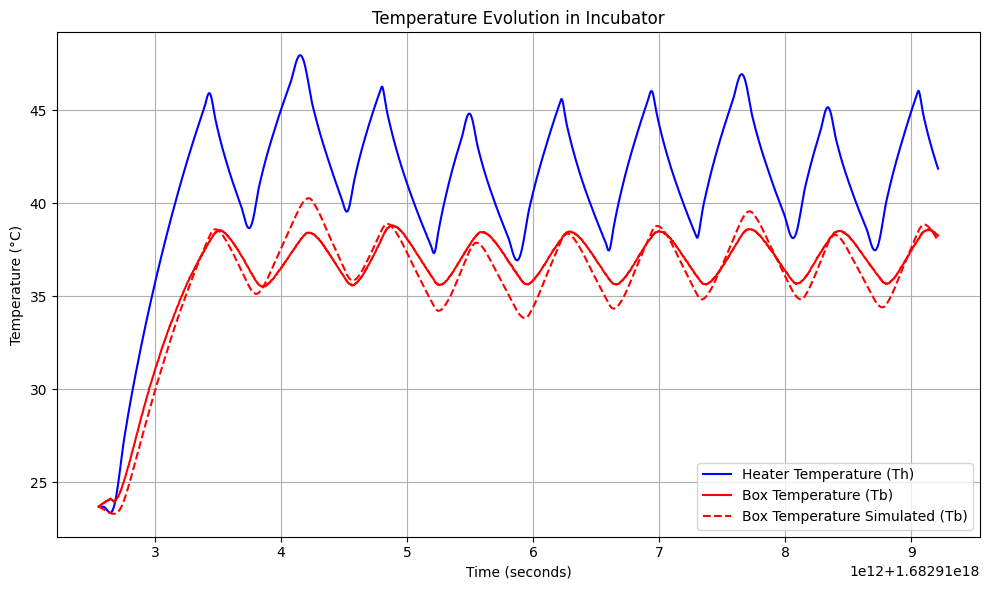

In [16]:
optimal_parameters = res.x
Ch,Cb,G_hb,G_br,Voltage,Current = optimal_parameters

sol = solve_ivp(
        lambda t, y: incubator_ode_with_varying_conditions(t, y, Ch, Cb, G_hb, G_br, Voltage, Current),
        t_span, y0, t_eval=t_eval)

Th_values = sol.y[0,:]
Tb_values = sol.y[1,:]

plt.figure(figsize=(10, 6))
# Omit heater temperature as not important since we do not have heater temperature data
plt.plot(data.time, Th_values, color='blue', label='Heater Temperature (Th)')
plt.plot(data.time, data.average_temperature, color='red', label='Box Temperature (Tb)')
plt.plot(data.time, Tb_values, color='red', linestyle="--", label='Box Temperature Simulated (Tb)')
plt.title('Temperature Evolution in Incubator')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Note how the calibration is not perfect. This is often the case, since our model simplifies the physics by quite a bit!

Also note how we now have a way to predict the heater temperature, even though we do not have a sensor for it. Our calibration would be improved if we had sensor data for the heater temperature, but we can be reasonably confident in our predictions of it, since the box temperatures are aligned.

# Exercises

1. Go back to the notebook [3-Physics-Modelling\2-ModellingIncubatorDynamics.ipynb](../3-Physics-Modelling\2-ModellingIncubatorDynamics.ipynb) and adjust the parameters of the model there, so that you can get a more realistic impression of how the controller works. Then adjust the controller parameters to ensure it works better (e.g., does not overshoot the maximum or undershoot the minimum temperature so much.)
2. Compare the above calibration code with the training of the neural network in [3-Physics-Modelling\4-TrainingIncubatorNN.ipynb](../3-Physics-Modelling\4-TrainingIncubatorNN.ipynb). What are the similarities and differences?
3. Just like in training of the neural network, we should have a training/test split of the data. Adjust the above code to do just that.